In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## Análise exploratória.

In [2]:
# Download at: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
df = pd.read_csv("olist_order_reviews_dataset.csv.zip")
df

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13


In [14]:
# Devemos verificar se existem valores nulos no dataset
df.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [15]:
# Temos que remover as linhas onde review_comment_message é nulo, pois é a coluna principal para a análise
df = df.dropna(subset=['review_comment_message'])

print(df.shape)
# A coluna review_comment não deve mais ter valores nulos.
df.isnull().sum()

(40977, 7)


review_id                      0
order_id                       0
review_score                   0
review_comment_title       31138
review_comment_message         0
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [16]:
def satisfaction(x):
    if x > 3:
        return "satisfied"
    else:
        return "not satisfied"

# Remove as linhas onde a nota é 3, pois não é muito relevante para a análise os neutros.
df = df[df["review_score"] != 3]

# A coluna review_score é a coluna alvo, e vamos transformar em uma coluna categórica -> "satisfied", "neutral", "not satisfied"
# Fazemos isso para que fique mais fácil de visualizar os resultados e faz sentido nesse caso agrupar ...
# ... as notas 4 e 5 como satisfeitos, 3 como neutro e 1 e 2 como insatisfeitos.
df["review_satisfaction"] = df["review_score"].apply(satisfaction)
df["review_satisfaction"].value_counts()

satisfied        26530
not satisfied    10890
Name: review_satisfaction, dtype: int64

In [17]:
# Remove acentuacao, para o modelo não cometer erros tipo: "nao" e "não" serem considerados palavras diferentes.
from unidecode import unidecode

# Junta o titulo com o texto da review em linhas que tem titulo.
df["review_comment_message"] = df["review_comment_title"].fillna("") + " " + df["review_comment_message"]

# Remove acentuacao
df["review_comment_message"] = df["review_comment_message"].apply(unidecode)
df["review_comment_message"]

3                    Recebi bem antes do prazo estipulado.
4         Parabens lojas lannister adorei comprar pela ...
9        recomendo aparelho eficiente. no site a marca ...
12         Mas um pouco ,travando...pelo valor ta Boa.\r\n
15       Super recomendo Vendedor confiavel, produto ok...
                               ...                        
99203     Tive um problema na entrega em que o correio ...
99205     para este produto recebi de acordo com a comp...
99208     Entregou dentro do prazo. O produto chegou em...
99221     Excelente mochila, entrega super rapida. Supe...
99223     meu produto chegou e ja tenho que devolver, p...
Name: review_comment_message, Length: 37420, dtype: object

In [18]:
# downloaded from https://gist.githubusercontent.com/alopes/5358189/raw/2107d809cca6b83ce3d8e04dbd9463283025284f/stopwords.txt
with open("stopwords_ptbr.txt", "r") as f:
    stopwords = f.readlines()
stopwords = list(map(lambda x: x.strip().replace("\n", ""), stopwords))
stopwords[1:10]

['a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para']

In [19]:
from sklearn.utils import resample

# Existem muito mais reviews satisfeitos do que insatisfeitos, então vamos balancear o dataset
satisfied = df[df["review_satisfaction"] == 'satisfied']
other = df[df['review_satisfaction'] != 'satisfied']

# Vamos fazer um undersampling, ou seja, vamos pegar uma amostra aleatória do dataset de reviews satisfeitos
n_samples = len(other)
satisfied_undersampled = resample(satisfied, replace=False, n_samples=n_samples, random_state=42)

# Agora vamos concatenar os dois datasets
df_balanced = pd.concat([satisfied_undersampled, other])
df_balanced["review_satisfaction"].value_counts()

satisfied        10890
not satisfied    10890
Name: review_satisfaction, dtype: int64

In [20]:
X = df_balanced["review_comment_message"].to_numpy()
Y = df_balanced["review_satisfaction"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15)

classificador = Pipeline(
    [
        ('meu_vetorizador', CountVectorizer(stop_words=stopwords, binary=True)),
        ('meu_classificador', LogisticRegression(penalty='l2', solver='saga', max_iter=10_000))
    ]
)

classificador.fit(X_train, y_train)
y_pred = classificador.predict(X_test)
acc = accuracy_score(y_pred, y_test)
print(acc)

0.9286807468625651


In [21]:
classificador.classes_
# Nao satisfeitos -> 0; Satisfeitos -> 1

array(['not satisfied', 'satisfied'], dtype=object)

(1, 10890)


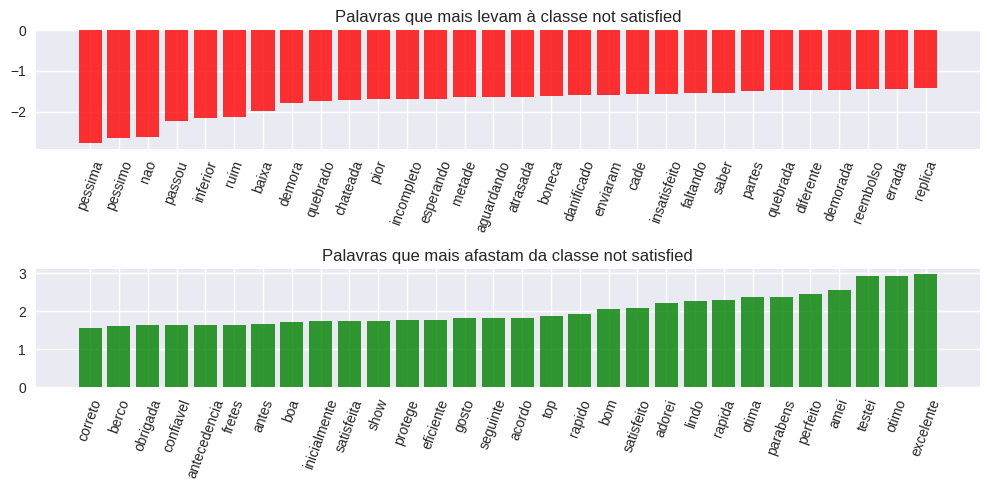

In [22]:
vocabulario = classificador['meu_vetorizador'].vocabulary_
pesos = classificador['meu_classificador'].coef_
print(pesos.shape)

# Para a classe Não satisfeitos.
classe_alvo = 0
classe_alvo_str = classificador.classes_[classe_alvo]

palavras_e_pesos = []
for palavra in vocabulario.keys():
    # Se a palavra é um numero, não a consideramos
    if palavra.isnumeric() or len(palavra) < 3:
        continue
    j = vocabulario[palavra]
    coeficiente = pesos[classe_alvo, j]
    palavras_e_pesos.append( (coeficiente, palavra) )

# Neste caso(regressor binário) -> os coeficientes que mais levam à insatisfação são os que tem o valor mais negativo.
# E os que mais afastam da insatisfação são os que tem o valor mais positivo.
tuplas_ordenadas = sorted(palavras_e_pesos, reverse=False) 
palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]

n_palavras = 30
eixo_x = np.arange(n_palavras)
fig = plt.figure(figsize=(10, 5))

# Use the seaborn style on matplotlib
plt.style.use('seaborn-v0_8')
plt.subplot(2, 1, 1)
plt.title(f'Palavras que mais levam à classe {classe_alvo_str}')
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras], color='red', alpha=0.8)
plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=70)

plt.subplot(2, 1, 2)
plt.title(f'Palavras que mais afastam da classe {classe_alvo_str}')
plt.bar(eixo_x[-n_palavras:], contagens[-n_palavras:], color='green', alpha=0.8)
plt.xticks(eixo_x[-n_palavras:], palavras[-n_palavras:], rotation=70)

fig.subplots_adjust(hspace=0.6)
plt.tight_layout()
plt.savefig('graf_resultados.png', dpi=300)
plt.show()